# GMMHMM for isolated word recognition
* HMM model for audio files of 6 categories ("khong", "nguoi", "viet_nam", "cua", "trong", "y_te")
* predicts corresponding labels on testing set
* visualize by confusion matrix

In [89]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix
import operator
import itertools
#import scipy.stats as sp
from scipy.io import wavfile
import math
from python_speech_features import mfcc
import pickle
import soundfile as sf

# Get MFCCs

In [94]:
# MFCC python_speech_features
def get_mfcc(audio_path):
    sr, y =  wavfile.read(audio_path)
    return mfcc(y, nfft=2048,winlen=0.025, winstep=0.01,\
                appendEnergy=True,winfunc=np.hamming, samplerate=sr, numcep=13)

In [92]:
def get_mfcc_(file_path):
    y, sr = librosa.load(file_path) # read .wav file
    hop_length = math.floor(sr*0.010) # 10ms hop
    win_length = math.floor(sr*0.025) # 25ms frame
    # mfcc is 12 x T matrix
    mfcc = librosa.feature.mfcc(
        y, sr, n_mfcc=12, n_fft=2048,
        hop_length=hop_length, win_length=win_length)
    # substract mean from mfcc --> normalize mfcc
    mfcc = mfcc - np.mean(mfcc, axis=1).reshape((-1,1)) 
    # delta feature 1st order and 2nd order
    delta1 = librosa.feature.delta(mfcc, order=1)
    delta2 = librosa.feature.delta(mfcc, order=2)
    # X is 36 x T
    X = np.concatenate([mfcc, delta1, delta2], axis=0) # O^r
    # return T x 36 (transpose of X)
    return X.T # hmmlearn use T x N matrix

# Const parameters
* num of state = 12
* 2 mixed gaussian
* num of iterator = 1000
* cov_type = "diag"

In [29]:
num_of_states = 12  
num_of_mix = 2  
covariance_type = 'diag'  # covariance type
n_iter = 1000  
dimension = 1

# Start probability

In [30]:
# Initial prior prob vector
def startProb():
    startProb = np.zeros(num_of_states)
    startProb[0: dimension] = 1/float(dimension)
    return startProb
startProb()

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Transition Matrix

In [31]:
# The initial transition matrix
def transitionMatrix():
    transmat_prior = (1 / float(dimension + 1)) * np.eye(num_of_states)

    for i in range(num_of_states - dimension):
        for j in range(dimension):
            transmat_prior[i, i + j + 1] = 1. / (dimension + 1)
    j = 0;
    for i in range(num_of_states - dimension, num_of_states):
        for j in range(num_of_states - i - j):
            transmat_prior[i, i + j] = 1. / (num_of_states - i)

    return transmat_prior
transitionMatrix()

array([[0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]])

# Model GMMHMM with 2 mix, Start prob and transition matrix

In [32]:
#Construct GMM + HMM based on passed parameters (n_mix, transmat_prior, startprob_prior)
def GMMHMM() :
    return hmm.GMMHMM(n_components = num_of_states, n_mix = num_of_mix,\
                      verbose=True,\
                      transmat_prior = transitionMatrix(), startprob_prior = startProb(), \
                      covariance_type = covariance_type, n_iter = n_iter)

# Model GaussianHMM with default 1 mix, None Start prob and None Transition matrix init

In [33]:
#Construct Gaussian HMM, i.e. GMM + HMM  1 mixture model
def GaussianHMM() :
    return hmm.GaussianHMM(n_components = num_of_states, \
                           verbose=True, \
                           #transmat_prior = transitionMatrix(), startprob_prior = startProb(), \
                           covariance_type = covariance_type, n_iter = n_iter)

# Training 

In [34]:
labels = []
words = [] 
features = []
hmmModels = []
folder_dir = '/Users/tien/Desktop/SpeechData' # Folder directory of the dataset, config this 

In [36]:
for file_name in os.listdir(folder_dir):
    features = np.array([])
    data_length = len(os.listdir(folder_dir + '/' + file_name))
    # Index to split data into two parts train/test (.8/.2) 
    training_index = int(data_length * 0.8)
    # loop and compute MFCC
    for audio_name in os.listdir(folder_dir + '/' + file_name)[0:training_index]:#train from 0 to index
        if len(features) == 0:
            features = get_mfcc(folder_dir + '/' + file_name + '/' + audio_name)
        else:
            features = np.append(features, get_mfcc(folder_dir + '/' + file_name + '/' + audio_name), axis=0)
        labels.append(file_name) # list labels (file name)
        if file_name not in words:
            words.append(file_name)
    #  GMMHMM model with parameter
    hmmModel = GMMHMM()
    np.seterr(all='ignore')
    print("---")
    # Train hmm model on MFCC features 
    hmmModel.fit(features)
    name = ("GMMHMM" +file_name)
    pickle.dump(hmmModel, open(name, 'wb'))
    print('Finished training for: ', file_name)
    hmmModels.append((hmmModel, file_name))# list models

---


         1    -2748943.6563             +nan
         2    -2319827.1367     +429116.5196
         3    -2241665.6001      +78161.5366
         4    -2224944.8579      +16720.7423
         5    -2219305.5503       +5639.3075
         6    -2217019.3229       +2286.2274
         7    -2215848.5894       +1170.7335
         8    -2214891.6219        +956.9675
         9    -2214191.3440        +700.2779
        10    -2213805.1831        +386.1609
        11    -2213578.6324        +226.5507
        12    -2213410.1324        +168.5000
        13    -2213274.8675        +135.2648
        14    -2213157.8079        +117.0597
        15    -2213049.8909        +107.9170
        16    -2212957.8508         +92.0400
        17    -2212876.8880         +80.9628
        18    -2212802.6004         +74.2876
        19    -2212722.9245         +79.6759
        20    -2212644.5880         +78.3364
        21    -2212568.4170         +76.1710
        22    -2212479.5388         +88.8781
        23

Finished training for:  yte
---


         1     -312417.4617             +nan
         2     -269872.4671      +42544.9946
         3     -263566.2344       +6306.2327
         4     -262448.5402       +1117.6942
         5     -262210.9917        +237.5485
         6     -262144.6482         +66.3435
         7     -262105.0225         +39.6257
         8     -262079.5139         +25.5086
         9     -262054.7293         +24.7847
        10     -262024.2660         +30.4632
        11     -262001.8960         +22.3700
        12     -261981.6560         +20.2400
        13     -261962.7187         +18.9373
        14     -261953.1804          +9.5383
        15     -261947.3343          +5.8460
        16     -261942.8001          +4.5343
        17     -261938.7742          +4.0258
        18     -261936.0118          +2.7624
        19     -261933.8132          +2.1986
        20     -261931.4234          +2.3899
        21     -261927.6965          +3.7268
        22     -261921.9646          +5.7319
        23

Finished training for:  cua
---


         1     -283714.0050             +nan
         2     -247980.9360      +35733.0690
         3     -242751.0510       +5229.8850
         4     -241859.4333        +891.6177
         5     -241566.3834        +293.0499
         6     -241404.5151        +161.8683
         7     -241302.1842        +102.3309
         8     -241237.2903         +64.8939
         9     -241193.2430         +44.0473
        10     -241149.9215         +43.3215
        11     -241090.9615         +58.9600
        12     -241003.3601         +87.6014
        13     -240880.9867        +122.3733
        14     -240814.0664         +66.9204
        15     -240794.1302         +19.9362
        16     -240787.3526          +6.7776
        17     -240786.7431          +0.6095
        18     -240798.5744         -11.8313


Finished training for:  trong
---


         1    -1783745.3561             +nan
         2    -1596063.8214     +187681.5347
         3    -1567032.0874      +29031.7341
         4    -1559046.0903       +7985.9970
         5    -1555843.8120       +3202.2784
         6    -1554274.1360       +1569.6760
         7    -1553468.2688        +805.8672
         8    -1552818.4853        +649.7835
         9    -1552071.4107        +747.0746
        10    -1550197.6289       +1873.7818
        11    -1548913.8565       +1283.7725
        12    -1548616.1857        +297.6707
        13    -1548474.4528        +141.7330
        14    -1548318.8199        +155.6328
        15    -1547957.3620        +361.4579
        16    -1547174.7944        +782.5676
        17    -1546301.2364        +873.5580
        18    -1546234.3346         +66.9018
        19    -1546177.7532         +56.5814
        20    -1546113.5422         +64.2110
        21    -1546044.2973         +69.2450
        22    -1545981.5978         +62.6995
        23

Finished training for:  vietnam
---


         1     -643070.6871             +nan
         2     -535460.7672     +107609.9199
         3     -512120.5072      +23340.2600
         4     -488719.4537      +23401.0536
         5      469363.4493     +958082.9030
         6      469529.4824        +166.0330
         7      469665.6499        +136.1675
         8      469804.7667        +139.1168
         9      469948.0425        +143.2758
        10      470043.4105         +95.3680
        11      470125.7931         +82.3826
        12      470192.2995         +66.5064
        13      470241.7614         +49.4619
        14      470291.8820         +50.1206
        15      470328.9476         +37.0656
        16      470341.7712         +12.8237
        17      470355.3880         +13.6168
        18      470362.7471          +7.3590
        19      470367.6355          +4.8885
        20      470371.2662          +3.6307
        21      470374.0885          +2.8223
        22      470376.3840          +2.2955
        23

Finished training for:  khong
---


         1    -1599982.2343             +nan
         2    -1353513.9787     +246468.2556
         3    -1267427.8341      +86086.1446
         4      509024.9977    +1776452.8318
         5      510780.5188       +1755.5211
         6      511930.8043       +1150.2855
         7      512428.3352        +497.5309
         8      512690.3670        +262.0317
         9      512835.3382        +144.9712
        10      512923.8521         +88.5139
        11      512978.3695         +54.5174
        12      513024.2086         +45.8391
        13      513068.2623         +44.0537
        14      513108.2053         +39.9430
        15      513149.3684         +41.1631
        16      513200.0771         +50.7087
        17      513271.5048         +71.4277
        18      513373.5065        +102.0018
        19      513490.0342        +116.5277
        20      513568.4881         +78.4539
        21      513610.8658         +42.3777
        22      513636.3278         +25.4620
        23

Finished training for:  nguoi


        40      513674.4011          +0.0084


In [37]:
with open("Models_parameters.txt", "w") as f:
    for i in hmmModels:
        model, label = i
        f.write(f"Model_name : {label}\n")
        f.write("Initial state occupation distribution\n")
        f.write(" ".join(map(str, model.startprob_)))
        f.write("\nMatrix of transition probabilities between states\n")
        f.write(" ".join(map(str, model.transmat_)))
        f.write("\nMean parameters for each mixture component in each state\n")
        f.write(" ".join(map(str, model.means_)))
        f.write("\nCovariance parameters for each mixture components in each state\n")
        f.write(" ".join(map(str, model.means_)))
        f.write("\n\n")

# Test

In [39]:
successful = 0
predicted_labels = []
real_labels = []
for file_name in os.listdir(folder_dir):
    data_length = len(os.listdir(folder_dir + '/' + file_name))
    testing_index = int(data_length * 0.8)# index 
    for audio_name in os.listdir(folder_dir + '/' + file_name)[testing_index:data_length]:# test from index to end
        features = get_mfcc(folder_dir + '/' + file_name + '/' + audio_name)
        probs = {}
        for item in hmmModels:
            hmm_model, label = item
            # Calculate score of each observation sequence (log likelihood)
            probs[label] = hmm_model.score(features)
        # Get key having the highest score 
        result = max(probs.items(), key=operator.itemgetter(1))[0]
        predicted_labels.append(result)
        real_labels.append(file_name)
        if (result == file_name):
            successful = successful + 1
print('Accuracy on testing set : ', (successful * 100 / len(real_labels)))

Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate

Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate

Degenerate mixture covariance
Degenerate mixture covariance
/Users/tien/miniconda3/envs/INT3411/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
Degenerate mixture covariance
Degenerate mixture covariance
/Users/tien/miniconda3/envs/INT3411/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
Degenerate mixture covariance
Degenerate mixture covariance
/Users/tien/miniconda3/envs/INT3411/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
Degenerate mixture covariance
Degenerate mixture covariance
/Users/tien/miniconda3/envs/INT3411/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
Degenerate mixture covariance
Degenerate mixture covariance
/Users/tien/miniconda3/e

Degenerate mixture covariance
Degenerate mixture covariance
/Users/tien/miniconda3/envs/INT3411/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
Degenerate mixture covariance
Degenerate mixture covariance
/Users/tien/miniconda3/envs/INT3411/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
Degenerate mixture covariance
Degenerate mixture covariance
/Users/tien/miniconda3/envs/INT3411/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
Degenerate mixture covariance
Degenerate mixture covariance
/Users/tien/miniconda3/envs/INT3411/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
Degenerate mixture covariance
Degenerate mixture covariance
/Users/tien/miniconda3/e

Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate

Accuracy on testing set :  97.00854700854701


In [20]:
print("num of successful predict: ", successful)
print("num of samples: ", len(real_labels))

num of successful predict:  457
num of samples:  468


# Plot Confusion Matrix

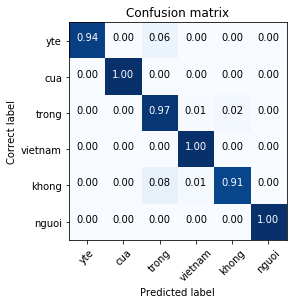

In [40]:
# Confusion matrix of testing set
conf_matrix = confusion_matrix(real_labels, predicted_labels)

#np.set_printoptions(precision=2)
#plt.figure()
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.xticks(range(len(words)), words, rotation=45)
plt.yticks(range(len(words)), words)
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], '.2f'),
             horizontalalignment="center",
             color="white" if i == j else "black")
#plt.tight_layout()
plt.ylabel('Correct label')
plt.xlabel('Predicted label')
plt.show()

# Prediction and Demo

In [41]:
import pyaudio
import wave
from pydub import AudioSegment
from pydub.playback import play

In [42]:
!pwd

/Users/tien/Downloads/hmm-word-recognition


In [43]:
def detect_leading_silence(sound, silence_threshold=-50.0, chunk_size=10):
    trim_ms = 0
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold:
        trim_ms += chunk_size

    return trim_ms

def trim_audio():
    sound = AudioSegment.from_file("data/output.wav", format="wav") 

    start_trim = detect_leading_silence(sound)
    end_trim = detect_leading_silence(sound.reverse())

    duration = len(sound)    
    trimmed_sound = sound[start_trim:duration-end_trim]
    
    trimmed_sound.export("data/output.wav", format="wav")
    play(trimmed_sound)

In [96]:
def record_audio():
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 2
    RATE = 44100
    RECORD_SECONDS = 1
    WAVE_OUTPUT_FILENAME = "data/output.wav" # hard coding for now

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    print ("* Listening...")

    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print ("* Done Listening")

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    # Write the data to a wav file
    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()


In [45]:
DATA_DIR = "/Users/tien/Downloads/hmm-word-recognition/data"

In [46]:
import librosa

In [47]:
!ls

GMMHMMcua
GMMHMMkhong
GMMHMMnguoi
GMMHMMtrong
GMMHMMvietnam
GMMHMMyte
Isolated word recognition using GMMHMMs.ipynb
Models_parameters.txt
data


In [136]:
def run_recognition_system_demo(directory):
    file_id = 'output'
    record_audio() 
    trim_audio()
    mfcc = get_mfcc(os.path.join(DATA_DIR, file_id + '.wav'))
    #y, sr = librosa.load(os.path.join(DATA_DIR, file_id + '.wav'))
    #get_mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=39).transpose().reshape(-1,1)
    mfcc = mfcc[0].reshape(-1, 1)
    probs = {} # save score(log_prob)
    labels = ["cua","khong","trong", "vietnam","yte","nguoi"]
    for i in labels:
        print(i)
        filename = ("GMMHMM"+i)
        #print(filename)
        gmmhmm = pickle.load(open(filename, 'rb'))
        probs[i]= gmmhmm.score(mfcc)
        print(probs[i])
    pred = max(probs.items(),key=operator.itemgetter(1))[0]
    print("prediction: ", pred)

run_recognition_system_demo(DATA_DIR)

* Listening...
* Done Listening


Degenerate mixture covariance
Degenerate mixture covariance


cua
-2230.8023069709943
khong
-1492.8192747242051
trong
-1801.9552357074074
vietnam
-1229.0184989764919
yte
-1795.6673695224636
nguoi
-926.9634458648219
prediction:  nguoi
